#Stationary Analysis



## Importación de librerías y datos

Por medio de nuestra libería ESIOS_contoller.py importamos nuestro último dataset de datos y lo parseamos para su uso. Sirve tanto como para Drive como jupiter.

In [0]:
import json, urllib, datetime, pickle, time
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import *
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
from keras.optimizers import *
from scipy.stats import *
from importlib.machinery import SourceFileLoader


try:
  from google.colab import drive
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/TFM/01.Utils/ESIOS_contoller.py'
  in_colab = True
except:
  path = '../utils/ESIOS_contoller.py'
  in_colab = False
  

esios_assembler = SourceFileLoader('esios', path).load_module()

esios_controller = esios_assembler.ESIOS(in_colab)
data_consumo = esios_controller.get_data('non-secuencial')

Using TensorFlow backend.


## Preparación de los datos

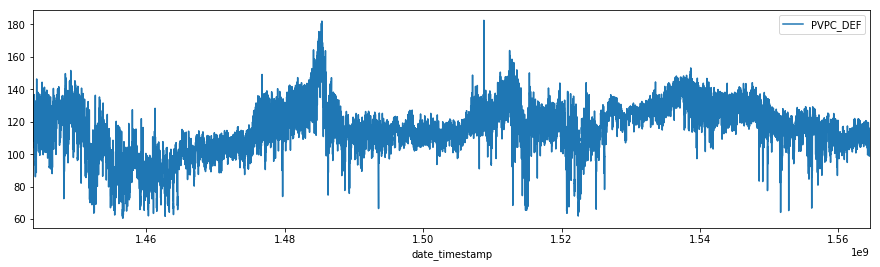

In [0]:
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

data = data_consumo[['date_timestamp', 'PVPC_DEF']]
data = data.set_index('date_timestamp')

train, test = train_test_split(data, test_size=0.2, random_state=0, shuffle=False)

data.plot(figsize=(15, 4))
pyplot.show()

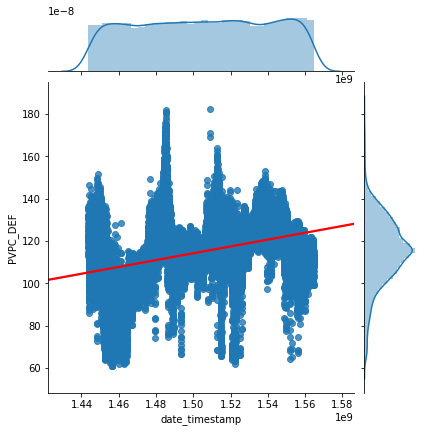

In [0]:
data_sns = data_consumo[['date_timestamp', 'PVPC_DEF']]
sns.jointplot(x="date_timestamp", y="PVPC_DEF",  kind='reg', data=data_sns,  joint_kws={'line_kws':{'color':'red'}})

<Figure size 360x72 with 0 Axes>

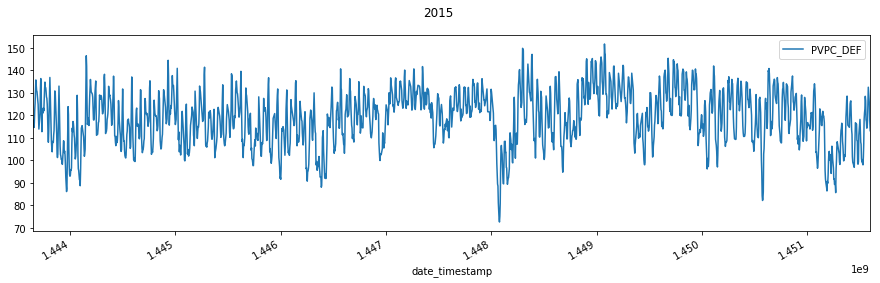

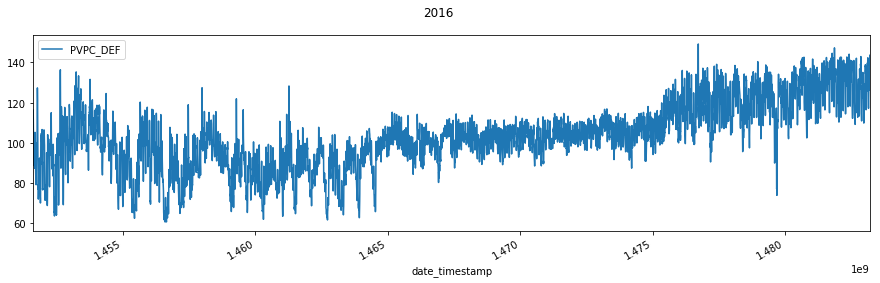

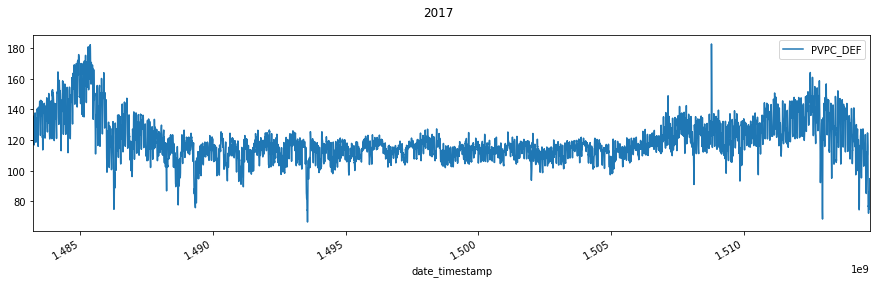

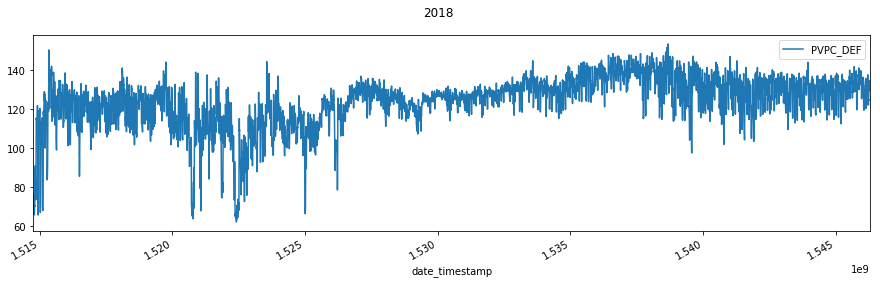

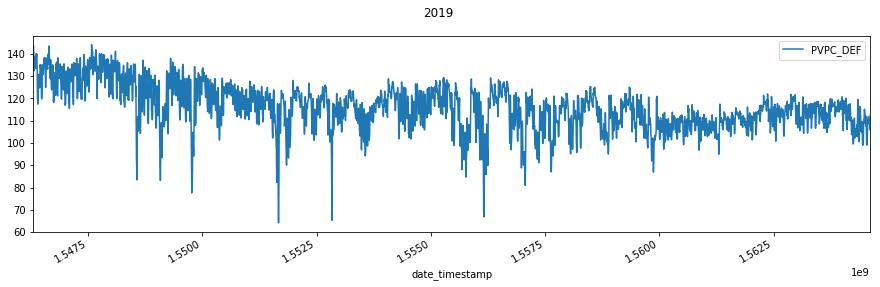

In [0]:
data_ano = data_consumo[['date_timestamp', 'PVPC_DEF']]

fig=plt.figure(figsize=(5, 1))

data_2015 = data_ano[:1912].set_index('date_timestamp')
data_2015.plot(subplots=True, title='2015',figsize=(15, 4))

data_2016 = data_ano[1912:9618].set_index('date_timestamp')
data_2016.plot(subplots=True, title='2016',figsize=(15, 4))

data_2017 = data_ano[9618:17583].set_index('date_timestamp')
data_2017.plot(subplots=True, title='2017',figsize=(15, 4))

data_2018 = data_ano[17583:25582].set_index('date_timestamp')
data_2018.plot(subplots=True, title='2018',figsize=(15, 4))

data_2019 = data_ano[25582:].set_index('date_timestamp')
data_2019.plot(subplots=True, title='2019',figsize=(15, 4))

plt.show()

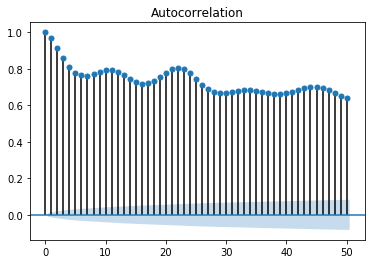

In [0]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data, lags=50)
pyplot.show()

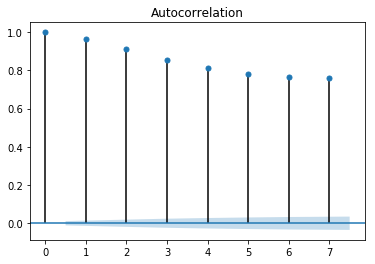

In [0]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data, lags=7)
pyplot.show()

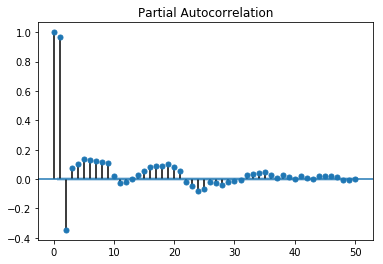

In [0]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data, lags=50)
pyplot.show()

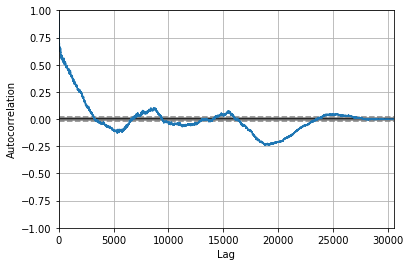

In [0]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data)
pyplot.show()

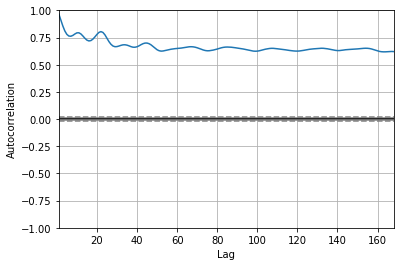

In [0]:
from pandas.compat import lmap
import matplotlib.pyplot as plt

def autocorrelation_plot_with_lags(series, lags=None, ax=None, **kwds):
    import matplotlib.pyplot as plt
    n = len(series)
    data = np.asarray(series)
    if ax is None:
        ax = plt.gca(xlim=(1, lags), ylim=(-1.0, 1.0))
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        return ((data[:n - h] - mean) *
                (data[h:] - mean)).sum() / float(n) / c0
    x = (np.arange(n) + 1).astype(int)
    y = lmap(r, x)
    z95 = 1.959963984540054
    z99 = 2.5758293035489004
    ax.axhline(y=z99 / np.sqrt(n), linestyle='--', color='grey')
    ax.axhline(y=z95 / np.sqrt(n), color='grey')
    ax.axhline(y=0.0, color='black')
    ax.axhline(y=-z95 / np.sqrt(n), color='grey')
    ax.axhline(y=-z99 / np.sqrt(n), linestyle='--', color='grey')
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    if lags:
        ax.plot(x[:lags], y[:lags], **kwds)
    else:
        ax.plot(x, y, **kwds)
    if 'label' in kwds:
        ax.legend()
    ax.grid()
    return ax
  
#Semana  
autocorrelation_plot_with_lags(data, lags=168)

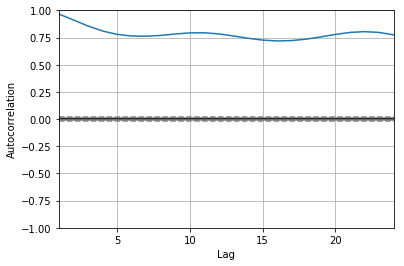

In [0]:
#Día
autocorrelation_plot_with_lags(data, lags=24)

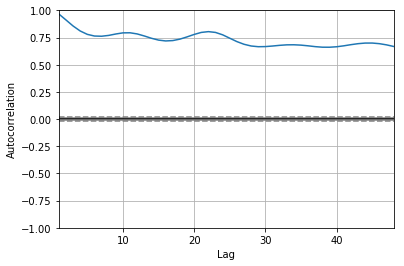

In [0]:
autocorrelation_plot_with_lags(data, lags=48)

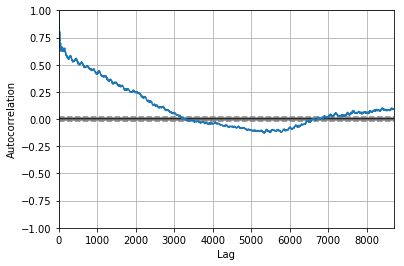

In [0]:
#AÑo
autocorrelation_plot_with_lags(data, lags=8700)

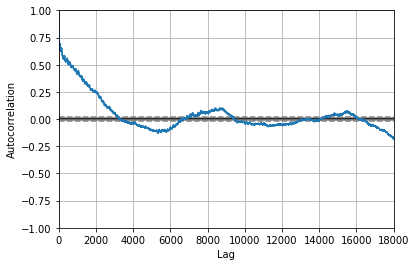

In [0]:
#2 años
autocorrelation_plot_with_lags(data, lags=18000)

#Podemos ver que tiene algo de correlacion con cada año anterior

## Dicker Fuller test

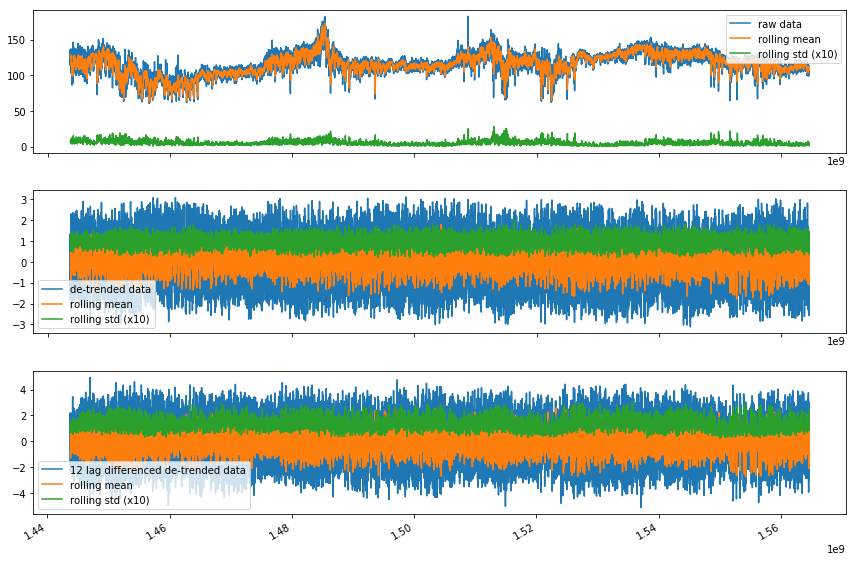

In [0]:
%matplotlib inline
df = data
df = df.rename(columns={"PVPC_DEF": "data"})

df['z_data'] = (df['data'] - df.data.rolling(window=12).mean()) / df.data.rolling(window=12).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(12)

def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df.index, df.data, label='raw data')
    ax[0].plot(df.data.rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df.data.rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=12).mean(), label="rolling mean");
    ax[1].plot(df.z_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df.index, df.zp_data, label="12 lag differenced de-trended data")
    ax[2].plot(df.zp_data.rolling(window=12).mean(), label="rolling mean");
    ax[2].plot(df.zp_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()   
    
    
plot_rolling(df)    

## ??? GROUP BY DAY

In [0]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df.data, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -7.502
P-value = 0.000
Critical values :
	1%: -3.430564393206591 - The data is  stationary with 99% confidence
	5%: -2.861634756059681 - The data is  stationary with 95% confidence
	10%: -2.5668204357489603 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -29.175
P-value = 0.000
Critical values :
	1%: -3.4305644775872515 - The data is  stationary with 99% confidence
	5%: -2.8616347933523274 - The data is  stationary with 95% confidence
	10%: -2.5668204555989282 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -39.930
P-value = 0.000
Critical values :
	1%: -3.4305645620343594 - The data is  stationary with 99% confidence
	5%: -2.8616348306743395 - The data is  stationary with 95% confidence
	10%: -2.566820475464527 - The data is  stationary with 90% confidence
